# Implementing Genetic Algorithm for Optimal Scheduling

In [ ]:
from deap import tools
from deap import algorithms

In [ ]:
!pip install deap


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 KB 5.0 MB/s eta 0:00:00


In [ ]:
def eaSimpleWithElitism(population, toolbox, cxpb, mutpb, ngen, stats = None, halloffame = None, verbose = __debug__):
  logbook = tools.Logbook()
  logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])

  invalid_ind = [ind for ind in population if not ind.fitness.valid]
  fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
  for ind, fit in zip (invalid_ind, fitnesses):
    ind.fitness.values = fit
  if halloffame is None:
    raise ValueError("halloffame parameter must not be empty!")

  halloffame.update(population)
  hof_size = len(halloffame.items) if halloffame.items else 0

  record = stats. compile(population) if stats else {}
  logbook.record(gen = 0, nevals = len(invalid_ind), **record)
  if verbose:
    print(logbook.stream)
  #generational process begins
  for gen in range(1 + ngen + 1):
    offspring = toolbox.select(population, len(population) - hof_size)
    offspring = algorithms.varAnd(offspring, toolbox, cxpb, mutpb)
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit
    offspring.extend(halloffame.items)
    halloffame.update(offspring)
    population[:] = offspring
    record = stats.compile(population) if stats else {}
    logbook.record(gen=gen, nevals=len(invalid_ind), **record)
    if verbose:
        print(logbook.stream)

  return population, logbook

In [ ]:
import numpy as np

class DocScheduling:
    def __init__(self, hardConstraintPenalty, softConstraintPenalty):
      self.hardConstraintPenalty = hardConstraintPenalty
      self.softConstraintPenalty = softConstraintPenalty
      self.doctors = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T']
      self.shiftPreference = [[1, 0, 1, 0], [0, 1, 0, 1], [0, 0, 1, 1], [1, 1, 1, 0], [0, 1, 1, 0], [1, 0, 1, 1], [1, 1, 1, 0], [0, 0, 1, 1], [1, 1,0, 0],[0, 1, 1, 1], [1, 0, 0, 1],  [1, 1, 1, 0], [0, 1, 1, 0], [1, 0, 1, 1], [1, 1, 1, 0], [0, 0, 1, 1], [0, 1, 0, 1], [0, 0, 1, 1], [0, 1, 0 , 1], [1,1,1,1]]
      self.shiftMin = [4, 4, 5, 4]
      self.shiftMax = [4, 5, 5, 4]
      self.burnout = [3.7, 4.6, 4.0, 4.3, 2.2, 2.5, 4.2, 2.5, 3.6, 6.7, 4.5, 5.2, 2.9, 6.9, 5.9, 3.9, 2.4, 3.2, 3.6, 5.1]
      self.maxShiftsPerWeek = 6
      self.weeks = 1
      self.shiftPerDay = len(self.shiftMin)
      self.shiftsPerWeek = 7 * self.shiftPerDay


    def __len__(self):
      return len(self.doctors) * self.shiftsPerWeek * self.weeks
  
    def getCost(self, schedule):
       

        if len(schedule) != self.__len__():
            raise ValueError("size of schedule list should be equal to ", self.__len__())

        docShiftsDict = self.getDocShifts(schedule)

        consecutiveShiftViolations = self.countConsecutiveShiftViolations(docShiftsDict)
        shiftsPerWeekViolations = self.countShiftsPerWeekViolations(docShiftsDict)[1]
        docPerShiftViolations = self.countDocsPerShiftViolations(docShiftsDict)[1]
        shiftPreferenceViolations = self.countShiftPreferenceViolations(docShiftsDict)
        docBurnoutViolations = self.countDocBurnoutViolations(docShiftsDict)

        hardContstraintViolations = consecutiveShiftViolations + docPerShiftViolations + shiftsPerWeekViolations
        softContstraintViolations = shiftPreferenceViolations + docBurnoutViolations 

        return self.hardConstraintPenalty * hardContstraintViolations + self.softConstraintPenalty * softContstraintViolations

    def getDocShifts(self, schedule):

        shiftsPerDoc = self.__len__() // len(self.doctors)
        docShiftsDict = {}
        shiftIndex = 0

        for doc in self.doctors:
            docShiftsDict[doc] = schedule[shiftIndex:shiftIndex + shiftsPerDoc]
            shiftIndex += shiftsPerDoc

        return docShiftsDict

    def countConsecutiveShiftViolations(self, docShiftsDict):

        violations = 0
        for docShifts in docShiftsDict.values():
            for shift1, shift2 in zip(docShifts, docShifts[1:]):
                if shift1 == 1 and shift2 == 1:
                    violations += 1
        return violations

    def countShiftsPerWeekViolations(self, docShiftsDict):

        violations = 0
        weeklyShiftsList = []
        for docShifts in docShiftsDict.values():  
            for i in range(0, self.weeks * self.shiftsPerWeek, self.shiftsPerWeek):
                weeklyShifts = sum(docShifts[i:i + self.shiftsPerWeek])
                weeklyShiftsList.append(weeklyShifts)
                if weeklyShifts > self.maxShiftsPerWeek:
                    violations += weeklyShifts - self.maxShiftsPerWeek

        return weeklyShiftsList, violations

    def countDocsPerShiftViolations(self, docShiftsDict):

        totalPerShiftList = [sum(shift) for shift in zip(*docShiftsDict.values())]

        violations = 0
        for shiftIndex, numOfDocs in enumerate(totalPerShiftList):
            dailyShiftIndex = shiftIndex % self.shiftPerDay  # -> 0, 1, or 2 for the 3 shifts per day
            if (numOfDocs > self.shiftMax[dailyShiftIndex]):
                violations += numOfDocs - self.shiftMax[dailyShiftIndex]
            elif (numOfDocs < self.shiftMin[dailyShiftIndex]):
                violations += self.shiftMin[dailyShiftIndex] - numOfDocs

        return totalPerShiftList, violations

    def countShiftPreferenceViolations(self, docShiftsDict):
  
        violations = 0
        for docIndex, shiftPreference in enumerate(self.shiftPreference):
            preference = shiftPreference * (self.shiftsPerWeek // self.shiftPerDay)
            shifts = docShiftsDict[self.doctors[docIndex]]
            for pref, shift in zip(preference, shifts):
                if pref == 0 and shift == 1:
                    violations += 1

        return violations
    
    def countDocBurnoutViolations(self, docShiftsDict):
        violations = 0
        totalPerShiftList = [sum(shift) for shift in zip(*docShiftsDict.values())]
        for shiftIndex, numOfDocs in enumerate(totalPerShiftList):
            dailyShiftIndex = shiftIndex % self.shiftPerDay
            for bs in self.burnout:
                violations = violations + (bs*dailyShiftIndex)
        return violations/20


    def printScheduleInfo(self, schedule):
        docShiftsDict = self.getDocShifts(schedule)

        print("Schedule for each doctor:")
        for doc in docShiftsDict:  
            print(doc, ":", docShiftsDict[doc])

        print("consecutive shift violations = ", self.countConsecutiveShiftViolations(docShiftsDict))
        print()

        weeklyShiftsList, violations = self.countShiftsPerWeekViolations(docShiftsDict)
        print("weekly Shifts = ", weeklyShiftsList)
        print("Shifts Per Week Violations = ", violations)
        print()

        totalPerShiftList, violations = self.countDocsPerShiftViolations(docShiftsDict)
        print("Doctors Per Shift = ", totalPerShiftList)
        print("Doctors Per Shift Violations = ", violations)
        print()

        shiftPreferenceViolations = self.countShiftPreferenceViolations(docShiftsDict)
        print("Shift Preference Violations = ", shiftPreferenceViolations)
        print()

        burnoutViolations = self.countDocBurnoutViolations(docShiftsDict)
        print("Doc Burnout Violations = ", burnoutViolations)
        print()

In [ ]:
def main():
    workers = DocScheduling(10, 7)

    randomSolution = np.random.randint(2, size=len(workers))
    print("Random Solution = ")
    print(randomSolution)
    print()

    workers.printScheduleInfo(randomSolution)

    print("Total Cost = ", workers.getCost(randomSolution))


if __name__ == "__main__":
    main()

Random Solution = 
[1 1 1 0 1 1 1 0 1 0 1 1 1 1 1 0 1 0 1 1 1 1 0 1 0 0 0 0 0 1 0 0 1 0 0 1 0
 1 0 0 1 1 1 1 0 1 0 0 0 0 1 1 1 0 1 0 1 0 0 1 1 0 0 1 1 1 1 1 0 1 1 1 1 1
 0 0 1 0 0 1 0 1 1 1 0 0 0 1 0 0 1 1 1 1 0 0 0 0 1 1 1 0 0 0 0 1 1 0 1 1 0
 1 1 0 0 1 1 1 0 1 1 0 1 0 1 0 1 1 0 0 1 1 0 1 0 1 0 1 1 1 0 1 0 0 1 0 0 0
 1 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 1
 0 1 0 0 1 1 0 0 1 1 1 1 0 0 0 0 0 1 0 1 1 0 1 0 1 1 1 0 0 0 1 1 1 0 0 1 1
 1 1 1 1 0 0 1 0 1 1 0 0 0 1 1 0 1 1 0 0 1 1 1 0 1 0 0 0 1 0 0 1 1 1 0 0 0
 0 0 0 1 0 1 0 0 0 0 1 1 0 0 1 1 1 1 1 0 1 1 0 0 0 0 1 0 0 1 0 0 0 1 0 0 1
 0 1 1 0 1 1 1 0 1 1 0 0 1 1 1 1 0 1 1 1 0 0 0 0 0 0 1 0 1 1 0 0 1 0 1 1 1
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 1 0 1 0 0 1 1 0 1 1 1 1 1 0 0
 1 1 0 1 1 0 0 0 1 0 1 1 0 1 0 1 1 1 0 0 0 1 0 0 0 0 1 1 1 1 1 1 0 0 0 1 1
 0 0 0 0 1 1 1 0 1 1 1 0 1 0 0 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 0 1 1 1 1 1 0
 0 0 1 1 1 1 0 0 0 0 1 1 1 0 1 0 0 1 1 1 1 1 1 1 0 0 1 0 0 0 0 0 1 1 0 1 1
 0 0 0

In [ ]:
from deap import base
from deap import creator
from deap import tools

import random
import numpy

import matplotlib.pyplot as plt
import seaborn as sns


HARD_CONSTRAINT_PENALTY = 10000  
SOFT_CONSTRAINT_PENALTY = 5000

POPULATION_SIZE = 300
P_CROSSOVER = 0.9  
P_MUTATION = 0.1   
MAX_GENERATIONS = 200
HALL_OF_FAME_SIZE = 30


RANDOM_SEED = 42
random.seed(RANDOM_SEED)

toolbox = base.Toolbox()

nsp = DocScheduling(HARD_CONSTRAINT_PENALTY, SOFT_CONSTRAINT_PENALTY)

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)
toolbox.register("zeroOrOne", random.randint, 0, 1)
toolbox.register("individualCreator", tools.initRepeat, creator.Individual, toolbox.zeroOrOne, len(nsp))
toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)

def getCost(individual):
    return nsp.getCost(individual), 


toolbox.register("evaluate", getCost)
toolbox.register("select", tools.selTournament, tournsize=2)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=1.0/len(nsp))


gen	nevals	min        	avg        
0  	300   	5.05995e+06	5.90467e+06
0  	238   	4.88995e+06	5.63773e+06
1  	241   	4.79995e+06	5.42753e+06
2  	247   	4.07495e+06	5.22595e+06
3  	246   	4.07495e+06	5.05262e+06
4  	245   	3.93495e+06	4.85653e+06
5  	243   	3.89495e+06	4.66647e+06
6  	248   	3.81495e+06	4.48665e+06
7  	247   	3.57495e+06	4.30002e+06
8  	238   	3.36495e+06	4.13895e+06
9  	237   	3.28995e+06	3.99353e+06
10 	250   	3.28995e+06	3.8283e+06 
11 	252   	3.03995e+06	3.69743e+06
12 	240   	3.03995e+06	3.5671e+06 
13 	247   	3.01995e+06	3.43672e+06
14 	233   	2.93495e+06	3.32253e+06
15 	247   	2.90495e+06	3.21653e+06
16 	239   	2.74495e+06	3.12227e+06
17 	250   	2.52995e+06	3.0187e+06 
18 	241   	2.52995e+06	2.91835e+06
19 	252   	2.46495e+06	2.81878e+06
20 	245   	2.39995e+06	2.7291e+06 
21 	243   	2.37995e+06	2.63912e+06
22 	240   	2.31995e+06	2.55413e+06
23 	232   	2.23995e+06	2.4898e+06 
24 	244   	2.13995e+06	2.43563e+06
25 	241   	2.05995e+06	2.37102e+06
26 	249   	2.03495e+

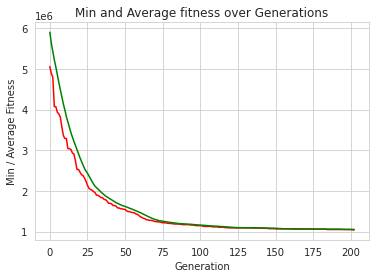

In [ ]:
def main():

    population = toolbox.populationCreator(n=POPULATION_SIZE)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", numpy.min)
    stats.register("avg", numpy.mean)
    hof = tools.HallOfFame(HALL_OF_FAME_SIZE)
    population, logbook = eaSimpleWithElitism(population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION,
                                              ngen=MAX_GENERATIONS, stats=stats, halloffame=hof, verbose=True)

    best = hof.items[0]
    print("-- Best Individual = ", best)
    print("-- Best Fitness = ", best.fitness.values[0])
    print()
    print("-- Schedule = ")
    nsp.printScheduleInfo(best)

    minFitnessValues, meanFitnessValues = logbook.select("min", "avg")

    sns.set_style("whitegrid")
    plt.plot(minFitnessValues, color='red')
    plt.plot(meanFitnessValues, color='green')
    plt.xlabel('Generation')
    plt.ylabel('Min / Average Fitness')
    plt.title('Min and Average fitness over Generations')
    plt.show()


if __name__ == "__main__":
    main()